In [1]:
using Revise

In [2]:
using MeshCatMechanisms
using MeshCat
using RigidBodyDynamics
using RigidBodySim
using Flux
using JLD2
using Plots; gr()
using LCPSim
using LearningMPC
using LearningMPC.Models
using DataFrames
using Blink

HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/9db0e137604e898c25f194d972715156bd46cb81-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/9db0e137604e898c25f194d972715156bd46cb81-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

INFO: Loading HttpServer methods...


In [3]:
robot = BoxAtlas(add_contacts=true)
position_bounds(findjoint(mechanism(robot), "floating_base")) .= RigidBodyDynamics.Bounds(-Inf, Inf)
mvis = MechanismVisualizer(robot)
open(mvis, Window())

Blink.AtomShell.Window(1, Blink.AtomShell.Electron(Process(`/home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/Blink/deps/atom/electron /home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/Blink/src/AtomShell/main.js port 6006`, ProcessRunning), TCPSocket(RawFD(63) active, 0 bytes waiting), Dict{String,Any}(Pair{String,Any}("callback", Blink.#1))), Blink.Page(1, WebSockets.WebSocket{TCPSocket}(TCPSocket(RawFD(55) active, 0 bytes waiting), true, CONNECTED::WebSockets.ReadyState = 1), Dict{String,Any}(Pair{String,Any}("webio", WebIO.#111),Pair{String,Any}("callback", Blink.#1)), Future(1, 1, 1, Nullable{Any}(true))))

In [21]:
interval_net, lqrsol = jldopen("boxatlas-regularized.jld2") do file
    file["net"], file["lqrsol"]
end
interval_net_mpc = LearningMPC.mpc_controller(robot, LearningMPC.LearnedCost(lqrsol, interval_net), Δt=0.05)

upperbound_net = jldopen("boxatlas-regularized-upperbound.jld2") do file
    file["net"]
end
upperbound_net_mpc = LearningMPC.mpc_controller(robot, LearningMPC.LearnedCost(lqrsol, upperbound_net), Δt=0.05)

lowerbound_net = jldopen("boxatlas-regularized-lowerbound.jld2") do file
    file["net"]
end
lowerbound_net_mpc = LearningMPC.mpc_controller(robot, LearningMPC.LearnedCost(lqrsol, lowerbound_net), Δt=0.05)

policy_net = jldopen("boxatlas-regularized-mimic.jld2") do file
    file["net"]
end

policy_net_controller = let net = policy_net
    function (τ, t, x)
        τ .= Flux.Tracker.data(net(LearningMPC.qv(x)))
    end
end

lqr_mpc = LearningMPC.mpc_controller(robot, lqrsol, Δt=0.05);

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only


In [15]:
state = nominal_state(robot)
set_velocity!(state, findjoint(mechanism(robot), "floating_base"), [0.5, 0.0, -0.0])
problem = LearningMPC.simulation_problem(state, mpc, 0.01, 4.0);
sol = solve(problem, Tsit5(), abs_tol = 1e-8, dt = 1e-6)
setanimation!(mvis, sol)

true

In [21]:
using DataFrames
using Plots; gr()

Plots.GRBackend()

In [22]:
policies = [(lqrsol, "LQR"), 
            (lqr_mpc, "MPC + LQR cost"),
            (policy_net_controller, "Policy Net"), 
            (interval_net_mpc, "MPC + Learned Interval"),
            (upperbound_net_mpc, "MPC + Learned Upper Bound"),
            (lowerbound_net_mpc, "MPC + Learned Lower Bound")]

tables = map(policies) do args
    controller, label = args
    LearningMPC.run_evaluations(
        controller,
        label,
        robot,
        lqrsol,
        [(1, [0])],
        [(1, linspace(-1.5, 1.5, 51))]; 
        mvis=mvis,
        horizon=400)
end
cost_table = vcat(tables...)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:44
Progress: 100%|█████████████████████████████████████████| Time: 0:13:25
Progress: 100%|█████████████████████████████████████████| Time: 0:01:40
Progress: 100%|█████████████████████████████████████████| Time: 0:12:26
Progress:  25%|██████████                               |  ETA: 0:10:40WARNING: Instability detected. Aborting
Progress: 100%|█████████████████████████████████████████| Time: 0:14:56
Progress:  33%|██████████████                           |  ETA: 0:07:41WARNING: Instability detected. Aborting
Progress: 100%|█████████████████████████████████████████| Time: 0:12:17


,controller,q0,v0,Δt,horizon,qf,vf,running_cost,terminal_cost
1,LQR,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[-1.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,400,"[-1.6388, -0.350276, 3.14239, 0.0341036, 0.00511864, 0.785504, -0.0501002, 0.800022, 0.800069, 0.950192, 0.474787]","[0.0100481, 0.000783546, -0.0878896, -0.0263762, 0.0260852, 0.00103568, -0.00020049, 0.00347217, -0.00380789, 0.000123049, 0.0003858]",28804.2,38828.3
2,LQR,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[-1.44, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,400,"[-1.62229, -0.350719, 3.14182, 0.0267766, 8.92236e-5, 0.785513, -0.0501006, 0.800096, 0.800107, 0.95018, 0.474771]","[-0.00277523, -0.0298253, -0.0329343, -0.0178183, 0.0153321, 9.25918e-5, -0.000122209, -0.00278448, -0.00572264, 0.000995424, 0.00150834]",28939.4,38658.9
3,LQR,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[-1.38, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,400,"[-1.54747, -0.350527, 3.14127, 0.00931979, -1.4137e-5, 0.785506, -0.0501, 0.800052, 0.800052, 0.950189, 0.474785]","[-0.0107906, 0.00136935, 0.0234532, -0.00307153, 0.000530824, -0.00010056, 1.69303e-6, -0.00116139, 0.000797456, 9.57467e-5, 2.30592e-5]",28392.0,37847.9
4,LQR,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[-1.32, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,400,"[-1.57765, -0.350509, 3.14151, 0.023229, 8.9869e-5, 0.785512, -0.0501014, 0.800064, 0.800061, 0.950189, 0.474784]","[0.0114129, -0.0043485, -0.0231942, 0.00400378, -0.00462086, 0.00027128, -6.6098e-5, 0.000516041, -0.00168447, 0.000149317, 0.000282058]",28349.2,38160.9
5,LQR,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[-1.26, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,400,"[-1.58153, -0.349654, 3.13903, 0.00809551, 0.0591917, 0.785506, -0.0501015, 0.800013, 0.80003, 0.950196, 0.474794]","[0.124877, 0.0391979, -0.170742, 0.0814831, -0.0794899, 6.40807e-5, -0.000746265, 0.00664657, -0.00232122, 0.00126662, 0.00159957]",28274.4,38079.0
6,LQR,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[-1.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,400,"[-1.65881, -0.35064, 3.14165, 0.00324545, -5.48035e-6, 0.785504, -0.0500998, 0.800043, 0.800078, 0.950188, 0.474782]","[-0.0208867, 0.0375868, 0.0364913, -0.0101432, 0.00152707, 0.000475296, -1.07839e-6, 0.00361011, 0.00694765, -0.000944297, -0.00166944]",27977.2,39091.3
7,LQR,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[-1.14, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,400,"[-1.72381, -0.348806, 3.1467, 0.0891403, 0.00331841, 0.785502, -0.0501005, 0.799715, 0.800044, 0.950197, 0.474794]","[-0.0307103, 0.0221193, 0.0145879, -0.0364049, 0.0321522, -0.000244708, 7.70514e-5, 0.0408529, 0.00230031, -0.000250775, -0.000432017]",27677.9,39903.3
8,LQR,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[-1.08, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,400,"[-1.63587, -0.350682, 3.14142, 0.00807543, -7.45292e-6, 0.785507, -0.0501001, 0.800064, 0.800078, 0.950186, 0.474779]","[-0.000322052, 0.0161928, -0.00425197, -0.00239615, 0.000381632, 0.00041466, -2.73082e-5, 0.00278165, 0.00217097, -0.000467162, -0.00072097]",27216.6,38812.2
9,LQR,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[-1.02, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,400,"[-1.69517, -0.34995, 3.14431, 0.0656877, 0.000517647, 0.785507, -0.0501, 0.800053, 0.800093, 0.950186, 0.474779]","[-0.00176408, 0.0608947, 0.00480854, -0.00347091, 0.000107369, 0.000661555, 8.93491e-5, 0.00904534, 0.00966959, -0.00229284, -0.00321443]",27177.2,39528.2
10,LQR,"[0.0, 0.82, 0.0, 0.2, 0.2, 0.0, 0.0, 0.7, 0.7, 0.82, 0.82]","[-0.96, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0.01,400,"[-1.68296, -0.350596, 3.14204, 0.0146656, 2.76564e-5, 0.785503, -0.0500996, 0.800031, 0.800091, 0.950188, 0.474781]","[-0.0125827, 0.02

In [23]:
@save "cost_table.jld2" cost_table

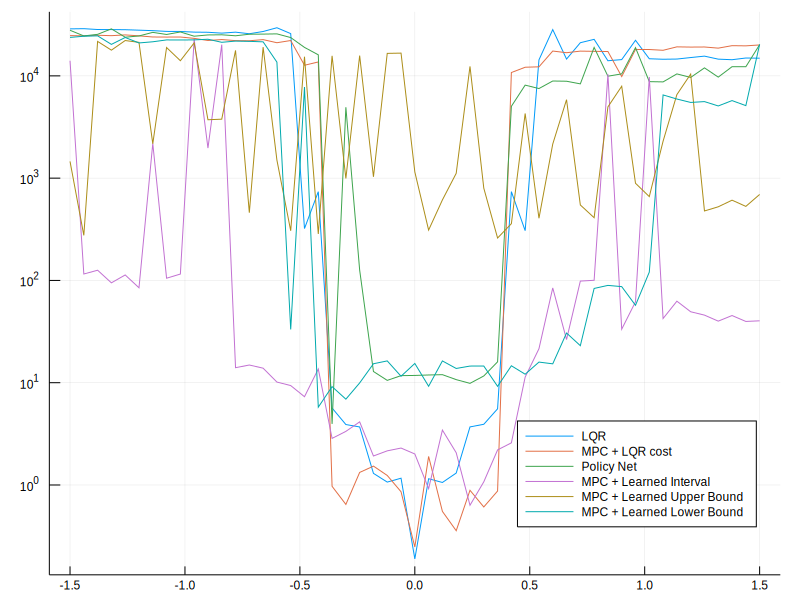

In [24]:
plt = plot(yscale=:log, legend=:bottomright, size=(800, 600))
for (controller, label) in policies
    xs = Float64[]
    ys = Float64[]
    for row in eachrow(cost_table)
        if row[:controller] == label
            push!(xs, row[:v0][1])
            push!(ys, row[:running_cost][1])
        end
    end
    plot!(plt, xs, ys, label=label)
end
plt

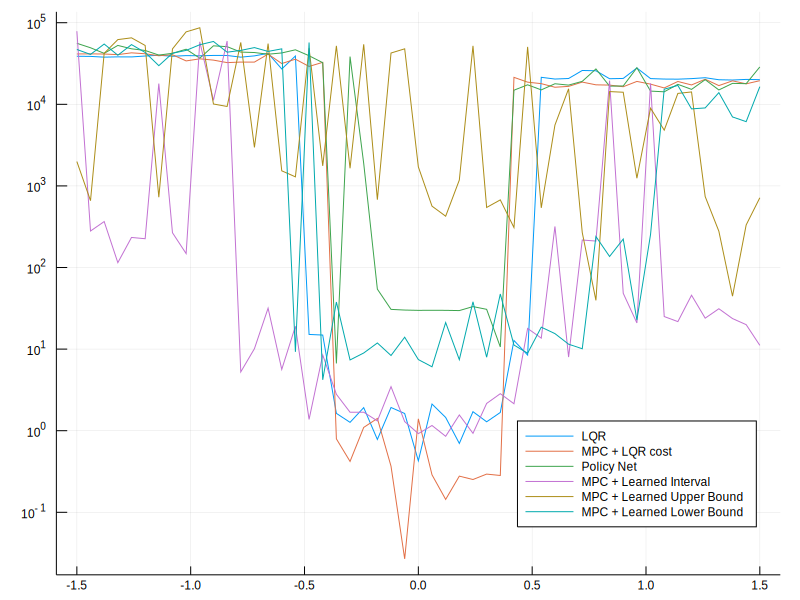

In [25]:
plt = plot(yscale=:log, legend=:bottomright, size=(800, 600))
for (controller, label) in policies
    xs = Float64[]
    ys = Float64[]
    for row in eachrow(cost_table)
        if row[:controller] == label
            push!(xs, row[:v0][1])
            push!(ys, row[:terminal_cost][1])
        end
    end
    plot!(plt, xs, ys, label=label)
end
plt